<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/dna_simulated_chip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep learning with DNA sequences

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from random import choice, randint
import numpy as np
import sys

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
plt.style.use('default')

import keras
import keras.backend as K
from keras import layers
from keras.models import Sequential, Model

Using TensorFlow backend.


In [0]:
def create_simulated_sequence(no,length = 128, cis = "AAATATCT"):
    def dna_sequence_generator(length):
        def weightedchoice(items):  # this doesn't require the numbers to add up to 100
            return choice("".join(x * y for x, y in items))
        #rice gc 43.54%
        DNA = ""
        for i in range(length):
            DNA += weightedchoice([("C", 22), ("G", 22), ("A", 28), ("T", 28)])
        return DNA
    def embed_motif(sequence, cis, position):
        embeded = sequence[:position] + cis + sequence[position + len(cis):]
        return embeded
    def one_hot(sequences):
        '''
        modified based on the codes from https://github.com/kundajelab/dragonn/blob/master/dragonn/utils.py
        '''
        sequence_length = len(sequences[0])
        integer_type = np.int8 if sys.version_info[0] == 2 else np.int32  # depends on Python version
        integer_array = LabelEncoder().fit(np.array(('ACGTN',)).view(integer_type)).transform(sequences.view(integer_type)).reshape(len(sequences), sequence_length)
        one_hot_encoding = OneHotEncoder(sparse=False, n_values=5, dtype=integer_type).fit_transform(integer_array)
        one_hot_encoding = one_hot_encoding.reshape(len(sequences), 1, sequence_length, 5)[:, :, :,[0, 1, 2, 4]]#.swapaxes(2, 3)[:, :, [0, 1, 2, 4], :]
        return one_hot_encoding
    
    p_sequences = []
    n_sequences = []

    for i in range(no):
        sequence = dna_sequence_generator(length)
        sequence = embed_motif(sequence,cis,randint(0,length - len(cis)))
        p_sequences.append(sequence)

        sequence = dna_sequence_generator(length)
        while sequence.find(cis)>-1:
            sequence = dna_sequence_generator(length)
        n_sequences.append(sequence)

    p_sequences = np.array(p_sequences)
    n_sequences = np.array(n_sequences)
    sequences = np.r_[p_sequences,n_sequences]
    sequences = np.array(sequences)
    oh_sequences = one_hot(sequences)
    oh_sequences = oh_sequences.astype('float32')
    labels = []
    for i in range(no):
        labels.append(np.array([1, 0]))
    for i in range(no):
        labels.append(np.array([0, 1]))
    labels = np.array(labels)
    labels = labels.astype('float32')

    return oh_sequences, labels

def oh2nucleotides(oh_sequence):
    sequence=[]
    for nucleotide in oh_sequence[0]:
        index = np.argmax(nucleotide)
        sequence += str(["A","C","G","T"][index])
        sequence = "".join(sequence)
    return sequence

#https://stackoverflow.com/questions/42615527/sequence-logos-in-matplotlib-aligning-xticks

fp = FontProperties(family="DejaVu Sans", weight="bold") 
globscale = 1.35
LETTERS = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }
COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen'}

def letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


## Prepare Synthetic Input Data

In [0]:
oh_sequences, labels = create_simulated_sequence(no=100,length=64,cis="AAATATCT")

print(oh_sequences.shape)
print(labels.shape)

(200, 1, 64, 4)
(200, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)


In [0]:
print(oh_sequences[0][0,:10])
sequences=oh2nucleotides(oh_sequences[0])
print(sequences[:10])

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
TCACCGTGAA


In [0]:
train_x, valid_x, train_y, valid_y = train_test_split(oh_sequences, labels, test_size=0.2, random_state=42,)

## Prepare CNN and Train

In [0]:
K.clear_session()

model = Sequential([
    layers.Conv2D(64,(1,16),input_shape=(1,64,4),activation="relu",padding="same",name="conv1"),
    layers.MaxPool2D((1,64)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(2,name="preprediction"),
    layers.Activation("softmax")
])
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 1, 64, 64)         4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
preprediction (Dense)        (None, 2)                 130       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 4,290
Trainable params: 4,290
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(train_x,train_y,epochs=50,validation_data=(valid_x,valid_y))

Train on 160 samples, validate on 40 samples
Epoch 1/50
160/160 [==============================] - 0s 2ms/step - loss: 0.7141 - acc: 0.5187 - val_loss: 0.6979 - val_acc: 0.4500
Epoch 2/50
160/160 [==============================] - 0s 251us/step - loss: 0.6785 - acc: 0.5500 - val_loss: 0.6930 - val_acc: 0.5500
Epoch 3/50
160/160 [==============================] - 0s 178us/step - loss: 0.6644 - acc: 0.6063 - val_loss: 0.6848 - val_acc: 0.6250
Epoch 4/50
160/160 [==============================] - 0s 186us/step - loss: 0.6449 - acc: 0.6188 - val_loss: 0.6846 - val_acc: 0.5000
Epoch 5/50
160/160 [==============================] - 0s 195us/step - loss: 0.6180 - acc: 0.7062 - val_loss: 0.6766 - val_acc: 0.5750
Epoch 6/50
160/160 [==============================] - 0s 178us/step - loss: 0.6013 - acc: 0.7687 - val_loss: 0.6684 - val_acc: 0.6000
Epoch 7/50
160/160 [==============================] - 0s 193us/step - loss: 0.5827 - acc: 0.7938 - val_loss: 0.6562 - val_acc: 0.7750
Epoch 8/50
160/160 

## Use the model

In [0]:
n = 10
inputs = valid_x[n:n+1]
predictions = model.predict(inputs)

print("correct label is",valid_y[n:n+1])
print("prediction is",predictions)

correct label is [[1. 0.]]
prediction is [[0.9342484  0.06575161]]


# Introduction to DL visualization

## Convolutional filter visualization.

In [0]:
wb = model.get_layer("conv1").get_weights()
weights, bias = wb
print(weights.shape)


(1, 16, 4, 64)


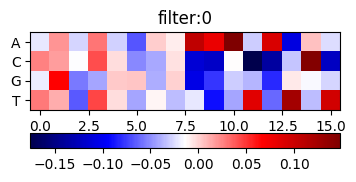

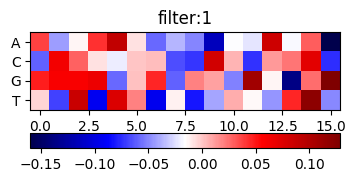

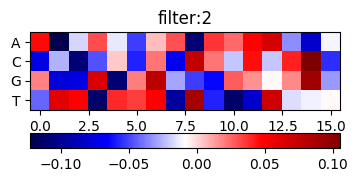

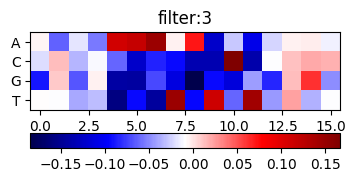

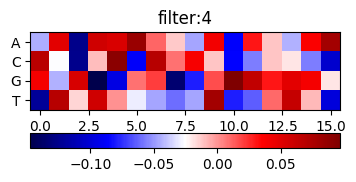

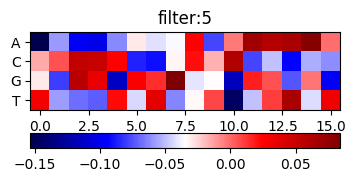

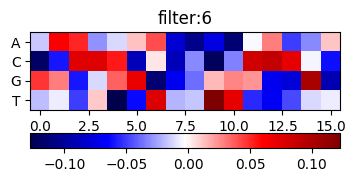

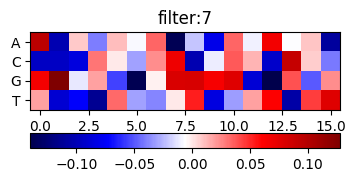

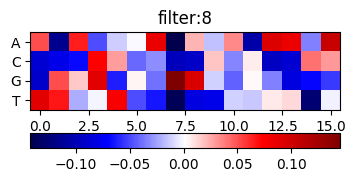

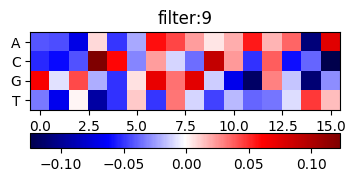

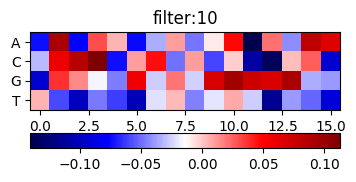

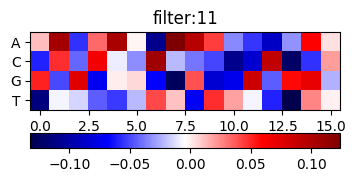

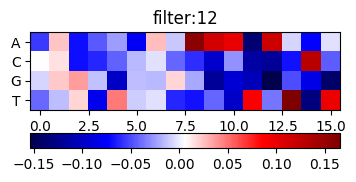

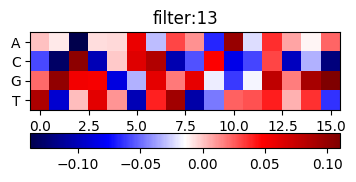

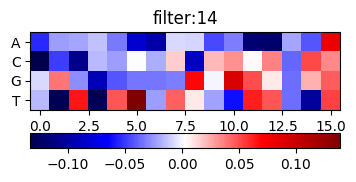

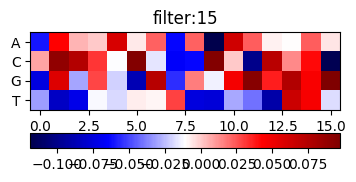

In [0]:
#by heatmap

for n in range(16):
    weight = weights[0,:,:,n]
    transposed_weight = weight.T
    title = "filter:" + str(n)
    plt.figure(figsize=(4,2))
    plt.title(title)
    plt.imshow(transposed_weight,cmap="seismic")
    plt.yticks(range(4),("A","C","G","T"))
    plt.colorbar(orientation="horizontal")
    plt.show()

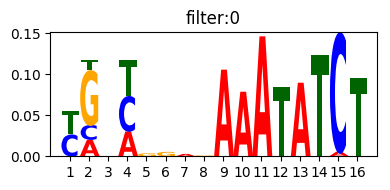

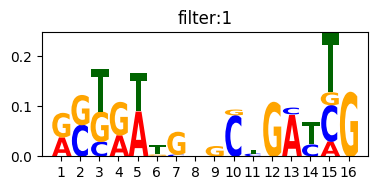

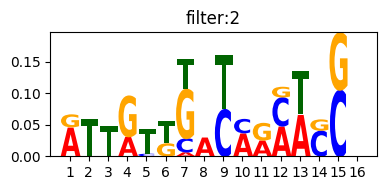

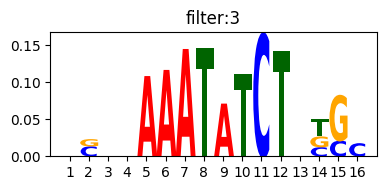

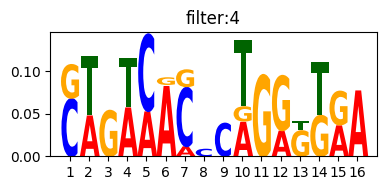

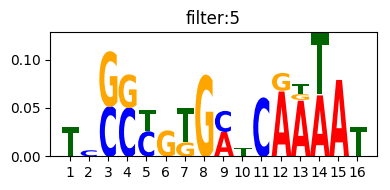

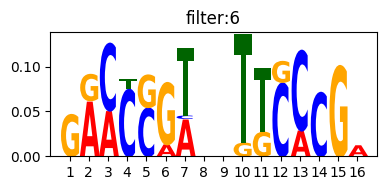

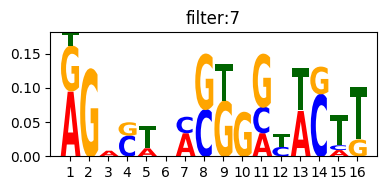

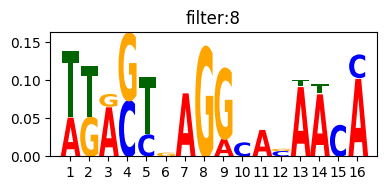

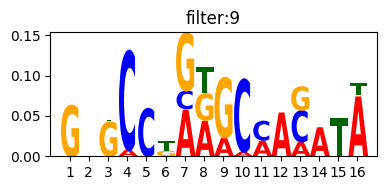

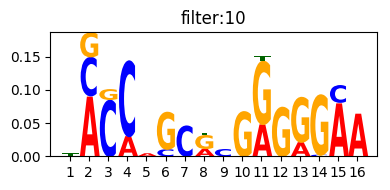

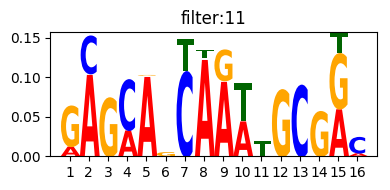

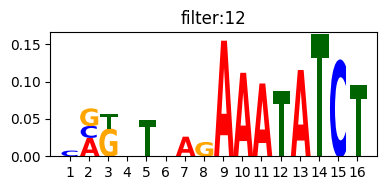

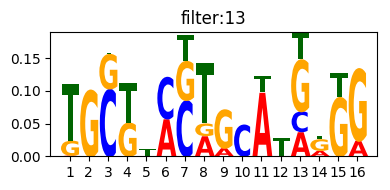

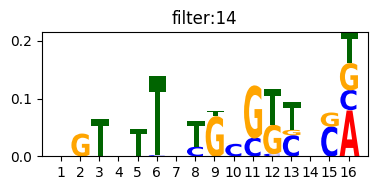

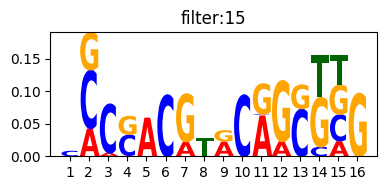

In [0]:
for n in range(16):
    weight = weights[0,:,:,n]
    matrix = []
    #relu function for visualization
    weight = weight.clip(min=0)
    for pos in weight:
        _m = []
        for letter, val in zip(["A","C","G","T"], pos):
            _m.append([letter,val])
        matrix.append(_m)

    fig, ax = plt.subplots(figsize=(4,2))

    all_scores = matrix
    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            letterAt(base, x,y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)
    title = "filter:" + str(n)
    plt.title(title)
    plt.xticks(range(1,x))
    plt.xlim((0, x)) 
    plt.ylim((0, maxi)) 
    plt.tight_layout()      
    plt.show()

## Backpropagation based visualization

In [0]:
def saliency_function(input_model):
    input_imgs = input_model.input
    layer_output = input_model.get_layer("preprediction").output[0,0]
    grads = K.gradients(layer_output,input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    return backprop_fn

saliency_fn = saliency_function(model)

In [0]:
n=10
inputs = valid_x[n:n+1]
#make sure that the label and prediction will output the correct label and  
print(valid_y[n:n+1])
print(model.predict(inputs))


#入力配列に対する勾配を得る
grads_val = saliency_fn([inputs, 0])[0]
print(grads_val.shape)

#余分な次元を取り除く
grads_val = grads_val[0][0].T
print(grads_val.shape)

[[1. 0.]]
[[0.9342484  0.06575161]]
(1, 1, 64, 4)
(4, 64)


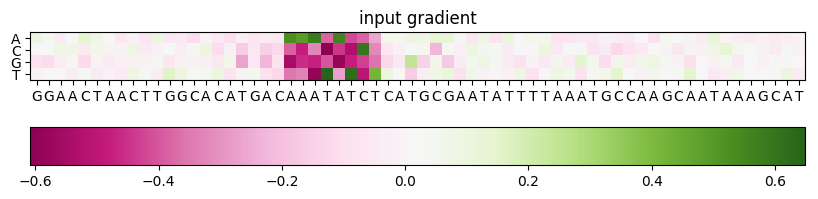

In [0]:
nucleotides = oh2nucleotides(valid_x[n:n+1][0])
#to list for x tick label
xlabel = [x for x in nucleotides]

plt.figure(figsize=(10,4))
plt.title("input gradient")
plt.imshow(grads_val,cmap="PiYGz")
plt.yticks(range(4),("A","C","G","T"))
plt.xticks(range(64),xlabel)
plt.colorbar(orientation="horizontal")
plt.show()